In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from vap.events.events import TurnTakingEvents, EventConfig
from vap.modules.lightning_module import VAPModule
from vap.data.datamodule import VAPDataset, VAPDataModule
from vap.utils.plot import plot_melspectrogram, plot_vad, plot_vap_probs

In [2]:
def plot_output(d, out):
    # Define the ratios for the subplot heights
    height_ratios = [2, 2, 1, 1, 1, 1]

    # Create the figure and the GridSpec instance with the given height ratios
    fig, ax = plt.subplots(nrows=6, sharex=True, figsize=(15, 6), gridspec_kw={'height_ratios': height_ratios, 'hspace': 0.01})

    plot_melspectrogram(d["waveform"], ax=ax[:2])
    # plot vad.
    # VAD is by default longer than the audio (for prediction)
    # See zeros at the end of the waveforms where the VAD is defined but the audio is not.
    x = torch.arange(d["vad"].shape[0]) / dset.frame_hz
    x2 = torch.arange(out["vad"].shape[1]) / dset.frame_hz
    plot_vad(x, d["vad"][:, 0], ax[0], ypad=3, color="b", label="VAD A")
    plot_vad(x, d["vad"][:, 1], ax[1], ypad=3, color="orange", label="VAD A")
    plot_vad(x2, out["vad"][0, :, 0], ax[0], ypad=3, color="w", label="VAD pred")
    plot_vad(x2, out["vad"][0, :, 1], ax[1], ypad=3, color="w", label="VAD pred")
    for i in range(4):
        plot_vap_probs(out['p'][i, 0], ax=ax[2+i])
    ax[0].set_xticks([])
    ax[1].set_xticks([])
    ax[0].legend()
    ax[1].legend()
    ax[-1].set_xticks(list(range(0, 1+round(x[-1].item())))) #list(range(0, 20)))
    ax[-1].set_xlabel("Time (s)")
    return fig, ax

In [3]:
def plot_event(evnt, ax, frame_hz=50):
    for shift in evnt:
        start = shift[0] / frame_hz
        end = shift[1] / frame_hz
        ch = shift[2]
        for aa in ax:
            aa.axvline(start, color='r')
            aa.axvline(end, color='r', linestyle='dashed')
        print("start: ", start)
        print("end: ", end)
        print("channel: ", ch)

In [11]:
CSV_PATH = "../example/data/splits/val.csv"
dset = VAPDataset(CSV_PATH)
print('Dataset: ', len(dset))

Dataset:  67160


In [12]:
df = dset.df

In [15]:
df['audio_path'] = df['audio_path'].apply(lambda x: x.replace('..', '/home/ubuntu'))

In [17]:
dset.df = df

In [5]:
CHECKPOINT_PATH = "../example/checkpoints/checkpoint.ckpt"
CHECKPOINT_PATH = "../runs_new/VAP2/myuzgo3v/checkpoints/epoch=12-step=46566.ckpt"
module = VAPModule.load_from_checkpoint(CHECKPOINT_PATH)
model = module.model

/home/ubuntu/miniconda3/envs/vap/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [18]:
conf = EventConfig(
    metric_time=0.05,
    equal_hold_shift=False,
    sh_pre_cond_time=0.5,
    sh_post_cond_time=0.5,
)
eventer = TurnTakingEvents(conf)

In [ ]:
row = torch.randint(0, len(dset), (1,)).item()

Events:  dict_keys(['pred_backchannel', 'pred_backchannel_neg', 'shift', 'hold', 'long', 'pred_shift', 'pred_shift_neg', 'short'])
waveform:  torch.Size([2, 320000])
vad:  torch.Size([1100, 2])
probs: torch.Size([1, 1000, 256])
vad: torch.Size([1, 1000, 2])
H: torch.Size([1, 1000])
p_now: torch.Size([1, 1000])
p_future: torch.Size([1, 1000])
p_all: torch.Size([1, 1000])
p: torch.Size([4, 1, 1000])
start:  3.06
end:  3.6
channel:  0
start:  4.82
end:  6.24
channel:  1


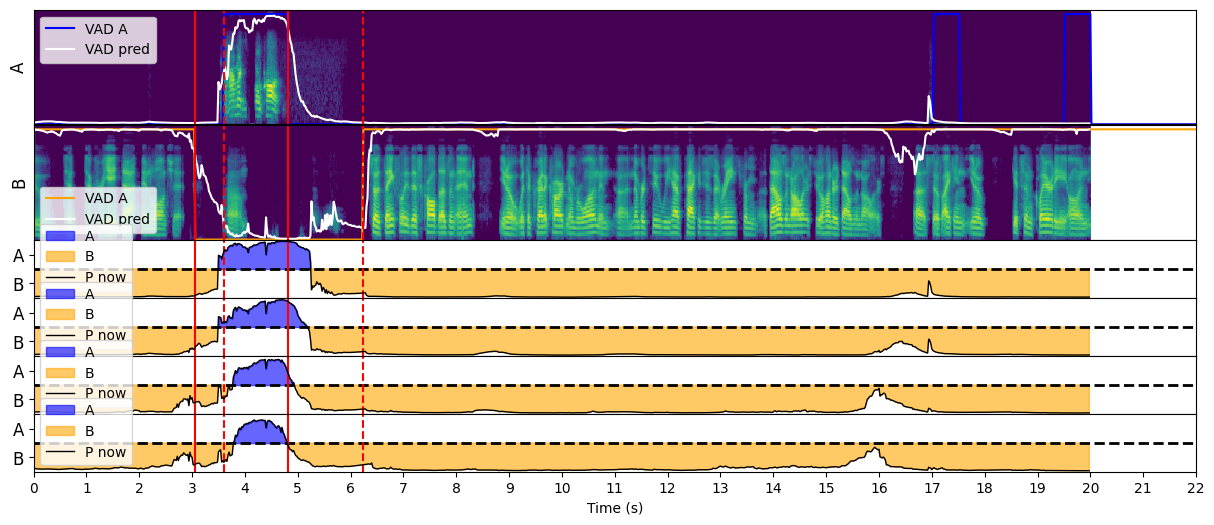

In [53]:
d = dset[row]
out = model.probs(d['waveform'].unsqueeze(0).to('cuda'))
events = eventer(d['vad'][:-100].unsqueeze(0))
print("Events: ", events.keys())
print("waveform: ", d['waveform'].shape)
print("vad: ", d['vad'].shape)
for feature_name, feature in out.items():
    print(f"{feature_name}: {feature.shape}")
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)

Events:  dict_keys(['pred_backchannel', 'pred_backchannel_neg', 'shift', 'hold', 'long', 'pred_shift', 'pred_shift_neg', 'short'])
waveform:  torch.Size([2, 320000])
vad:  torch.Size([1100, 2])
probs: torch.Size([1, 1000, 256])
vad: torch.Size([1, 1000, 2])
H: torch.Size([1, 1000])
p_now: torch.Size([1, 1000])
p_future: torch.Size([1, 1000])
p_all: torch.Size([1, 1000])
p: torch.Size([4, 1, 1000])
start:  3.06
end:  3.6
channel:  0
start:  4.82
end:  6.24
channel:  1


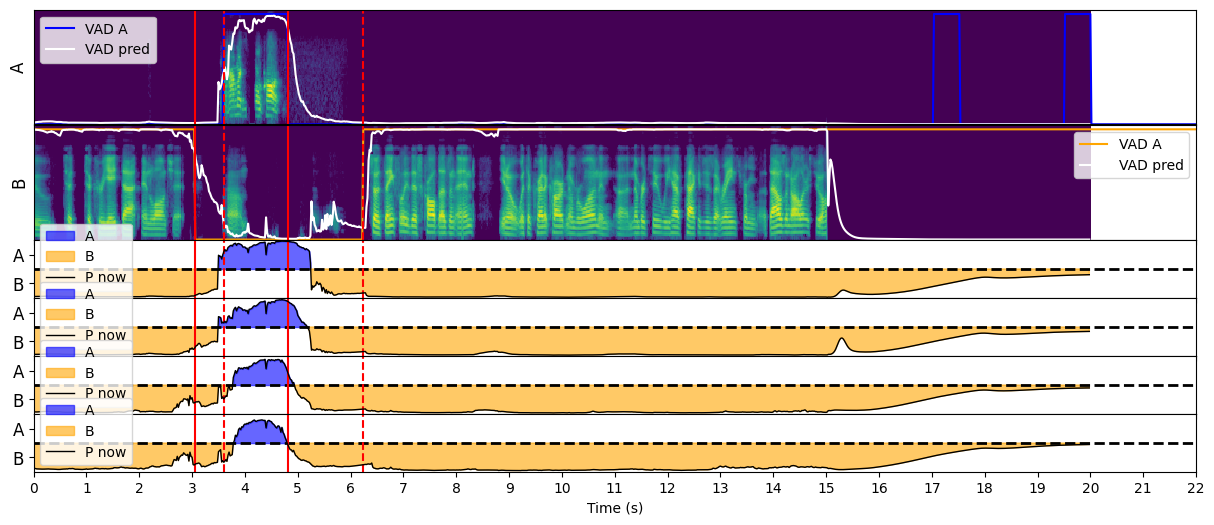

In [54]:
# Mask in the middle
x_masked = d['waveform']
start, end = int(dset.sample_rate * 15), int(dset.sample_rate * 20)
x_masked[:, start:end] = 0
out = model.probs(x_masked.unsqueeze(0).to('cuda'))
d['waveform'] = x_masked
events = eventer(d['vad'][:-100].unsqueeze(0))
print("Events: ", events.keys())
print("waveform: ", d['waveform'].shape)
print("vad: ", d['vad'].shape)
for feature_name, feature in out.items():
    print(f"{feature_name}: {feature.shape}")
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)

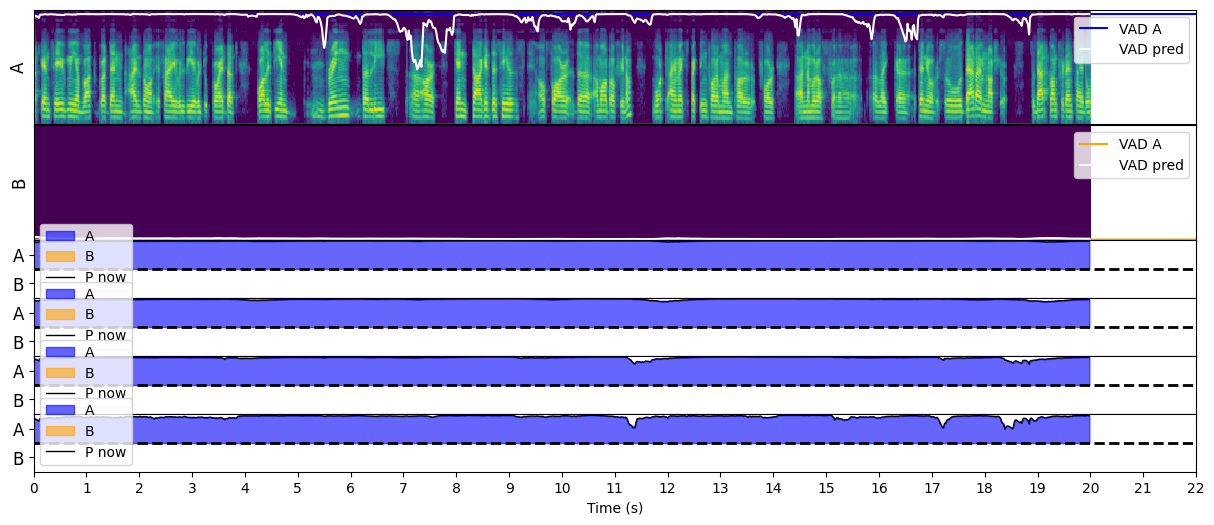

In [35]:
fig, ax = plot_output(d, out)
plot_event(events['shift'][0], ax)

In [122]:
plt.show()